In [ ]:
# import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:


# Le chemin est marqué par r'' (raw string) pour gérer les anti-slashes Windows
# VEUILLEZ VÉRIFIER L'EXACTITUDE de ce chemin, y compris l'extension du fichier (.csv)
# Si l'erreur persiste, l'une des parties de ce chemin est incorrecte sur votre machine.
file_path = '../Data/Camp_Market_Cleaned_Grade.csv'

try:
    df = pd.read_csv(file_path)

    # Affichage en cas de succès
    print("✅ Fichier chargé avec succès !")
    print("\n--- Tête du DataFrame ---")
    print(df.head())

except FileNotFoundError:
    # Affichage en cas d'échec
    print(" ERREUR: Fichier non trouvé.")
    print(f"Vérifiez que ce chemin est correct : {file_path}")
    print("\n💡 Suggestions :")
    print("  1. Confirmez l'orthographe exacte de tous les dossiers et du fichier.")
    print("  2. Vérifiez si l'extension est bien '.csv' et non '.xlsx' ou autre.")

✅ Fichier chargé avec succès !

--- Tête du DataFrame ---
     ID  Year_Birth   Education Marital_Status  Income Dt_Customer  \
0  5524        1957  Graduation         Single   58138  04/09/2012   
1  2174        1954  Graduation         Single   46344  08/03/2014   
2  4141        1965  Graduation         Couple   71613  21/08/2013   
3  6182        1984  Graduation         Couple   26646  10/02/2014   
4  5324        1981         PhD         Couple   58293  19/01/2014   

   Last_Purchase  MntWines  MntFruits  MntMeatProducts  ...  Z_CostContact  \
0             58       635         88              546  ...              3   
1             38        11          1                6  ...              3   
2             26       426         49              127  ...              3   
3             26        11          4               20  ...              3   
4             94       173         43              118  ...              3   

   Z_Revenue  Response  Customer_For_Months  Childre

Entraînement du modèle Gradient Boosting...
Entraînement terminé.

=== Performance Gradient Boosting ===
AUC: 0.8526
Precision: 0.6875
Recall: 0.3626
Matrice de confusion :
[[506  15]
 [ 58  33]]


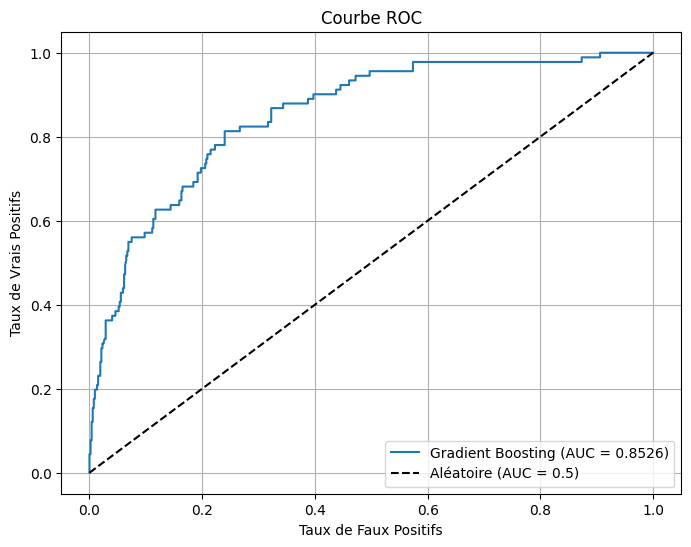


Top 10 des Features Influentes (Gradient Boosting):
Recency                  0.1789
AcceptedCmp3             0.1156
AcceptedCmp5             0.1091
Income                   0.0928
MntMeatProducts          0.0713
AcceptedCmp1             0.0536
Age                      0.0499
MntSweetProducts         0.0464
MntGoldProds             0.0456
Marital_Status_Single    0.0398
dtype: float64


C:\Users\nseke\AppData\Local\Temp\ipykernel_23708\3571476324.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_feature_importance.values, y=gb_feature_importance.index, palette="plasma")


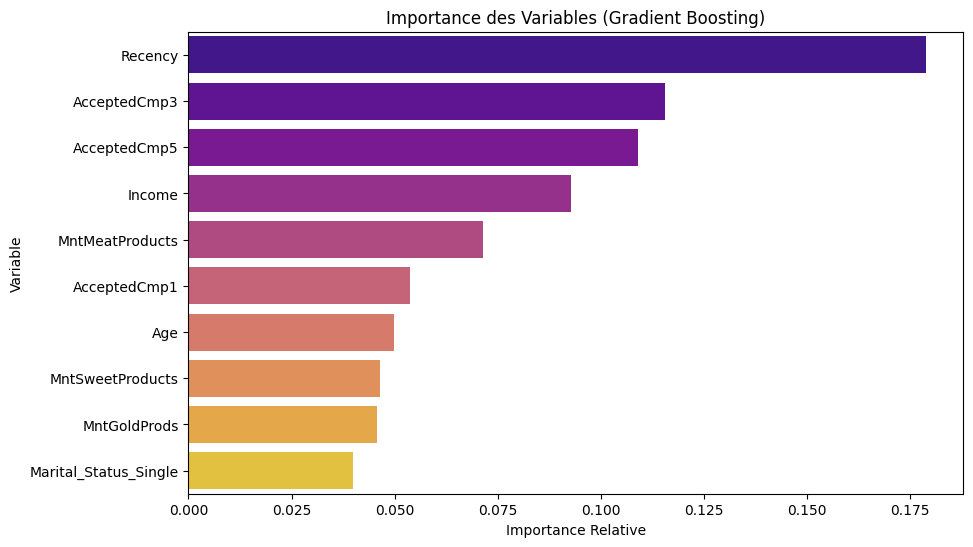

In [6]:
# ----------------------------------------------------------------------
# 1. Préparation des données
# ----------------------------------------------------------------------
df.rename(columns={'Last_Purchase': 'Recency'}, inplace=True)

def assign_kids_teens(childrens):
    if childrens == 0:
        return 0, 0
    elif childrens == 1:
        return 1, 0
    elif childrens == 2:
        return 1, 1
    else:
        return 2, 1
    
df[['Kidhome', 'Teenhome']] = df['Childrens'].apply(lambda x: pd.Series(assign_kids_teens(x)))

rfm_features = [col for col in df.columns if col.startswith('Mnt')] + ['Recency']
demographic_features = ['Income', 'Year_Birth', 'Kidhome', 'Teenhome']
categorical_features = ['Education', 'Marital_Status']
campaign_history_features = [col for col in df.columns if col.startswith('AcceptedCmp')]
feature_cols = rfm_features + demographic_features + categorical_features + campaign_history_features

data = df[feature_cols + ['Response']].copy() 
data.dropna(subset=['Income'], inplace=True)
data['Age'] = 2025 - data['Year_Birth']
data.drop('Year_Birth', axis=1, inplace=True)

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ----------------------------------------------------------------------
# 2. Préprocessing et Pipeline Gradient Boosting
# ----------------------------------------------------------------------
numeric_features = [col for col in X_train.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=100))
])

# Entraînement
print("Entraînement du modèle Gradient Boosting...")
pipeline_gb.fit(X_train, y_train)
print("Entraînement terminé.")

# ----------------------------------------------------------------------
# 3. Évaluation
# ----------------------------------------------------------------------
y_pred_proba = pipeline_gb.predict_proba(X_test)[:, 1]
y_pred = pipeline_gb.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n=== Performance Gradient Boosting ===")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Matrice de confusion :")
print(conf_matrix)

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------
# 4. Importance des variables
# ----------------------------------------------------------------------
one_hot_encoder = pipeline_gb.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = list(one_hot_encoder.get_feature_names_out(categorical_features))
feature_names = numeric_features + encoded_feature_names

gb_importances = pipeline_gb.named_steps['classifier'].feature_importances_
gb_feature_importance = pd.Series(gb_importances, index=feature_names).sort_values(ascending=False).head(10)

print("\nTop 10 des Features Influentes (Gradient Boosting):")
print(gb_feature_importance.round(4))

plt.figure(figsize=(10,6))
sns.barplot(x=gb_feature_importance.values, y=gb_feature_importance.index, palette="plasma")
plt.title('Importance des Variables (Gradient Boosting)')
plt.xlabel('Importance Relative')
plt.ylabel('Variable')
plt.show()


In [ ]:
# Exemple de données fictives
test_data = pd.DataFrame({
    'MntWines': [500, 200],
    'MntFruits': [50, 100],
    'MntMeatProducts': [100, 150],
    'MntFishProducts': [50, 80],
    'MntSweetProducts': [20, 40],
    'MntGoldProds': [10, 5],
    'Recency': [10, 50],
    'Income': [40000, 60000],
    'Kidhome': [1, 0],
    'Teenhome': [0, 1],
    'Education': ['Graduation', 'PhD'],
    'Marital_Status': ['Married', 'Single'],
    'AcceptedCmp1': [0, 1],
    'AcceptedCmp2': [1, 0],
    'AcceptedCmp3': [0, 0],
    'AcceptedCmp4': [1, 1],
    'AcceptedCmp5': [0, 0],
    'Age': [30, 45],  # ajouter Age directement
    'Response': [0, 1]  # juste pour correspondre au format, sera ignoré
})

# Sauvegarder dans un CSV
# Pour correspondre à la structure de sortie, enregistrer sous le dossier Prédiction à la racine
test_csv_path = "../Prédiction/test_nouvelles_donnees.csv"
test_data.to_csv(test_csv_path, index=False)
print(f"CSV de test créé : {test_csv_path}")


CSV de test créé : test_nouvelles_donnees.csv


In [ ]:
# Charger le CSV de test
test_df = pd.read_csv(test_csv_path)

# Faire la prédiction avec le pipeline entraîné ci-dessus (Gradient Boosting)
predictions = pipeline_gb.predict(test_df)
test_df['prediction'] = predictions

# Sauvegarder le résultat
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_file = f"../Prédiction/resultats_predictions_test_{timestamp}.csv"
test_df.to_csv(output_file, index=False)

print(f"Prédictions terminées et sauvegardées dans '{output_file}'")
print(test_df)

Prédictions terminées et sauvegardées dans 'resultats_predictions_test_2025-10-27_11-42-40.csv'
   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0       500         50              100               50                20   
1       200        100              150               80                40   

   MntGoldProds  Recency  Income  Kidhome  Teenhome   Education  \
0            10       10   40000        1         0  Graduation   
1             5       50   60000        0         1         PhD   

  Marital_Status  AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  \
0        Married             0             1             0             1   
1         Single             1             0             0             1   

   AcceptedCmp5  Age  Response  prediction  
0             0   30         0           0  
1             0   45         1           0  
